# Prediction of m6A sites in all SG-NEx direct RNA-Seq samples
* Predict m6A RNA modifications in all samples from the SG-NEx data using your method.
* Describe the results and compare them across the different cell lines. 
* Summarise and visualise your observations.

In [1]:
# import packages
import pandas as pd
import numpy as np
import json 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from collections import Counter
from glob import glob
from IPython.display import Image

# initial model 
import xgboost as xgb
from xgboost import XGBClassifier 
from math import ceil

from sklearn import preprocessing

MODEL_DIR = os.path.join(os.path.expanduser('~'), 'studies/ProjectStorage/tanyeejet/models') # models' size not as big as data, save in s3 for everyone 

## Predict m6a RNA modifications in SG-NEx data

In [2]:
# json data
files = glob('../data/m6anet/*/*.json')

In [3]:
os.path.split(files[0])

('../data/m6anet/SGNex_A549_directRNA_replicate5_run1', 'data.json')

In [4]:
# load model
model = XGBClassifier()
model.load_model('../outputs/xgb.model')
# with open(os.path.join(MODEL_DIR, 'xgb4_1_feature_names.pickle'), 'rb') as f:
#     model.get_booster().feature_names = pickle.load(f)

In [5]:
# utils
import json
import pandas as pd
from tqdm import tqdm

def get_data_dataframe(path):
    instance_lists = []
    num_lines = sum(1 for line in open(path))

    with open(path) as f, tqdm(total=num_lines, desc=f"[INFO] Reading in lines from {path}") as progress_bar:
        for transcript_json in f:
            transcript_dict = json.loads(transcript_json)
            for transcript_id, transcript_pos_dict in transcript_dict.items():
                for transcript_pos, nucleotides_dict in transcript_pos_dict.items():
                    for nucleotides, data in nucleotides_dict.items():
                        for row in data:
                            instance_lists.append([transcript_id, transcript_pos, nucleotides] + row)
            progress_bar.update(1)

    print("[INFO] Converting lines into a dataframe...")

    df = pd.DataFrame(instance_lists, columns=["transcript_id", "transcript_position", "nucleotides", "0", "1", "2", "3", "4", "5", "6", "7", "8"])
    df = df.astype({"transcript_position": "int"})

    return df

def process_data_dataframe(df):
    print("[INFO] Preparing features...")

    mean_df = df.groupby(by=['transcript_id', 'transcript_position', 'nucleotides']).mean().reset_index()

    min_df = df.groupby(by=['transcript_id', 'transcript_position', 'nucleotides']).min().reset_index()
    min_df.columns = ['transcript_id', 'transcript_position', 'nucleotides', '9', '10', '11', '12', '13', '14', '15', '16', '17']

    max_df = df.groupby(by=['transcript_id', 'transcript_position', 'nucleotides']).max().reset_index()
    max_df.columns = ['transcript_id', 'transcript_position', 'nucleotides', '18', '19', '20', '21', '22', '23', '24', '25', '26']

    complete_df = mean_df.merge(min_df).merge(max_df)
    complete_df = complete_df.astype({"transcript_position": "int"})

    feature_names = [str(feature) for feature in range(27)]

    return complete_df, feature_names


In [7]:
from xgboost import XGBClassifier

for f in files:
    # Read in data json and convert it into a dataframe
    df = get_data_dataframe(f)

    # Process the dataframe to generate new features
    df, features = process_data_dataframe(df)

    # Selecting relevant features
    Xte = df[features]

    print("[INFO] Loading model...")
    model = XGBClassifier()
    model.load_model('../outputs/xgb.model')

    print("[INFO] Running inference...")
    yhat_probs = model.predict_proba(Xte, iteration_range=(0, model.best_iteration + 1))
    yhat = model.predict(Xte, iteration_range=(0, model.best_iteration + 1))
    yhat1_probs = yhat_probs[:, 1]
    df["score"] = yhat1_probs
    df["pred_label"] = yhat

    print(f"[INFO] Saving predictions at {os.path.split(f)[0]}...")
    outdir = os.path.split(f)[0]
    df.to_csv(os.path.join(outdir, 'data.csv'), index=False)
    
    print("[INFO] Done.")

[INFO] Reading in lines from ../data/m6anet/SGNex_A549_directRNA_replicate5_run1/data.json: 100%|█| 1008933/1008933 [00:


[INFO] Converting lines into a dataframe...
[INFO] Preparing features...
[INFO] Loading model...
[INFO] Running inference...
[INFO] Saving predictions at ../data/m6anet/SGNex_A549_directRNA_replicate5_run1...
[INFO] Done.


[INFO] Reading in lines from ../data/m6anet/SGNex_K562_directRNA_replicate6_run1/data.json: 100%|█| 999100/999100 [00:55


[INFO] Converting lines into a dataframe...
[INFO] Preparing features...
[INFO] Loading model...
[INFO] Running inference...
[INFO] Saving predictions at ../data/m6anet/SGNex_K562_directRNA_replicate6_run1...
[INFO] Done.


[INFO] Reading in lines from ../data/m6anet/SGNex_HepG2_directRNA_replicate6_run1/data.json: 100%|█| 1564890/1564890 [01


[INFO] Converting lines into a dataframe...
[INFO] Preparing features...
[INFO] Loading model...
[INFO] Running inference...
[INFO] Saving predictions at ../data/m6anet/SGNex_HepG2_directRNA_replicate6_run1...
[INFO] Done.


[INFO] Reading in lines from ../data/m6anet/SGNex_MCF7_directRNA_replicate4_run1/data.json: 100%|█| 1446022/1446022 [01:


[INFO] Converting lines into a dataframe...
[INFO] Preparing features...
[INFO] Loading model...
[INFO] Running inference...
[INFO] Saving predictions at ../data/m6anet/SGNex_MCF7_directRNA_replicate4_run1...
[INFO] Done.


[INFO] Reading in lines from ../data/m6anet/SGNex_Hct116_directRNA_replicate4_run3/data.json: 100%|█| 1599747/1599747 [0


[INFO] Converting lines into a dataframe...
[INFO] Preparing features...
[INFO] Loading model...
[INFO] Running inference...
[INFO] Saving predictions at ../data/m6anet/SGNex_Hct116_directRNA_replicate4_run3...
[INFO] Done.


[INFO] Reading in lines from ../data/m6anet/SGNex_K562_directRNA_replicate4_run1/data.json: 100%|█| 1104444/1104444 [00:

[INFO] Converting lines into a dataframe...


[INFO] Preparing features...
[INFO] Loading model...
[INFO] Running inference...
[INFO] Saving predictions at ../data/m6anet/SGNex_K562_directRNA_replicate4_run1...
[INFO] Done.


[INFO] Reading in lines from ../data/m6anet/SGNex_Hct116_directRNA_replicate3_run1/data.json: 100%|█| 1391230/1391230 [0


[INFO] Converting lines into a dataframe...
[INFO] Preparing features...
[INFO] Loading model...
[INFO] Running inference...
[INFO] Saving predictions at ../data/m6anet/SGNex_Hct116_directRNA_replicate3_run1...
[INFO] Done.


[INFO] Reading in lines from ../data/m6anet/SGNex_K562_directRNA_replicate5_run1/data.json: 100%|█| 1052601/1052601 [00:


[INFO] Converting lines into a dataframe...
[INFO] Preparing features...
[INFO] Loading model...
[INFO] Running inference...
[INFO] Saving predictions at ../data/m6anet/SGNex_K562_directRNA_replicate5_run1...
[INFO] Done.


[INFO] Reading in lines from ../data/m6anet/SGNex_A549_directRNA_replicate6_run1/data.json: 100%|█| 1500579/1500579 [01:


[INFO] Converting lines into a dataframe...
[INFO] Preparing features...
[INFO] Loading model...
[INFO] Running inference...
[INFO] Saving predictions at ../data/m6anet/SGNex_A549_directRNA_replicate6_run1...
[INFO] Done.


[INFO] Reading in lines from ../data/m6anet/SGNex_Hct116_directRNA_replicate3_run4/data.json: 100%|█| 1302514/1302514 [0


[INFO] Converting lines into a dataframe...
[INFO] Preparing features...
[INFO] Loading model...
[INFO] Running inference...
[INFO] Saving predictions at ../data/m6anet/SGNex_Hct116_directRNA_replicate3_run4...
[INFO] Done.


[INFO] Reading in lines from ../data/m6anet/SGNex_HepG2_directRNA_replicate5_run2/data.json: 100%|█| 1580887/1580887 [02


[INFO] Converting lines into a dataframe...
[INFO] Preparing features...
[INFO] Loading model...
[INFO] Running inference...
[INFO] Saving predictions at ../data/m6anet/SGNex_HepG2_directRNA_replicate5_run2...
[INFO] Done.


[INFO] Reading in lines from ../data/m6anet/SGNex_MCF7_directRNA_replicate3_run1/data.json: 100%|█| 1446022/1446022 [01:


[INFO] Converting lines into a dataframe...
[INFO] Preparing features...
[INFO] Loading model...
[INFO] Running inference...
[INFO] Saving predictions at ../data/m6anet/SGNex_MCF7_directRNA_replicate3_run1...
[INFO] Done.


In [8]:
# processed json data + `score`, `pred_label`
files = glob('../data/m6anet/*/*.csv')

In [9]:
files

['../data/m6anet/SGNex_A549_directRNA_replicate5_run1/data.csv',
 '../data/m6anet/SGNex_K562_directRNA_replicate6_run1/data.csv',
 '../data/m6anet/SGNex_HepG2_directRNA_replicate6_run1/data.csv',
 '../data/m6anet/SGNex_MCF7_directRNA_replicate4_run1/data.csv',
 '../data/m6anet/SGNex_Hct116_directRNA_replicate4_run3/data.csv',
 '../data/m6anet/SGNex_K562_directRNA_replicate4_run1/data.csv',
 '../data/m6anet/SGNex_Hct116_directRNA_replicate3_run1/data.csv',
 '../data/m6anet/SGNex_K562_directRNA_replicate5_run1/data.csv',
 '../data/m6anet/SGNex_A549_directRNA_replicate6_run1/data.csv',
 '../data/m6anet/SGNex_Hct116_directRNA_replicate3_run4/data.csv',
 '../data/m6anet/SGNex_HepG2_directRNA_replicate5_run2/data.csv',
 '../data/m6anet/SGNex_MCF7_directRNA_replicate3_run1/data.csv']

### Combine dfs

In [10]:
dfs = []
for f in files:
    tmp = pd.read_csv(f)
    tmp['filename'] = f.split('/')[3]
    tmp['cell_line'] = f.split('/')[3].split('_')[1]
    dfs.append(tmp.copy())

In [11]:
dfa = pd.concat(dfs, axis=0)

In [12]:
dfa.head()

,transcript_id,transcript_position,nucleotides,0,1,2,3,4,5,6,...,21,22,23,24,25,26,score,pred_label,filename,cell_line
0,ENST00000000233,244,AAGACCA,0.007508,3.651206,122.913953,0.008808,7.602272,125.881395,0.006921,...,0.023240,19.179000,132.4,0.016694,11.270,88.1,0.047435,0,SGNex_A549_directRNA_replicate5_run1,A549
1,ENST00000000233,261,CAAACTG,0.006349,3.278738,108.936957,0.006346,3.196754,108.713043,0.006464,...,0.015538,10.604471,114.7,0.022149,8.977,102.4,0.132322,0,SGNex_A549_directRNA_replicate5_run1,A549
2,ENST00000000233,316,GAAACAG,0.006867,2.751946,105.810417,0.007035,3.441285,99.585417,0.007406,...,0.017260,4.790000,104.4,0.016600,4.810,96.6,0.031219,0,SGNex_A549_directRNA_replicate5_run1,A549
3,ENST00000000233,332,AGAACAT,0.009808,6.241867,129.901961,0.008623,2.834246,98.135294,0.006187,...,0.026575,6.397000,103.4,0.021607,5.115,97.0,0.466363,0,SGNex_A549_directRNA_replicate5_run1,A549
4,ENST00000000233,368,AGGACAA,0.010308,6.118964,118.431373,0.011881,5.924688,122.358824,0.009710,...,0.032981,10.968474,129.3,0.029880,8.339,91.5,0.577043,1,SGNex_A549_directRNA_replicate5_run1,A549


In [13]:
dfa.columns

Index(['transcript_id', 'transcript_position', 'nucleotides', '0', '1', '2',
       '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15',
       '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26',
       'score', 'pred_label', 'filename', 'cell_line'],
      dtype='object')

### dfs grouped by cell line

In [10]:
# dfcnames = list(set([dfname.split('_')[1] for dfname in dfnames]))

In [11]:
# dfcs = []
# for dfcname in dfcnames:
#     tmp = [df for dfname, df in zip(dfnames, dfs) if dfcname in dfname]
#     dfcs.append(pd.concat(tmp, axis=0))

## Describe results and compare across different cell lines
* A549: adenocarcinomic human alveolar basal epithelial cells
* Hct116: human colon cancer cell line
* HepG2: human liver cancer cell line
* MCF7: breast cancer cell line
* K562: leukemia cell line

### % m6a modification in each cell line

In [14]:
perc_m6a = dfa.groupby('cell_line')['pred_label'].value_counts(normalize=True)[:, 1].reset_index()
perc_m6a['pred_label'] = perc_m6a['pred_label'] * 100

In [15]:
perc_m6a.round(3)

,cell_line,pred_label
0,A549,4.382
1,Hct116,5.507
2,HepG2,5.211
3,K562,3.755
4,MCF7,4.138


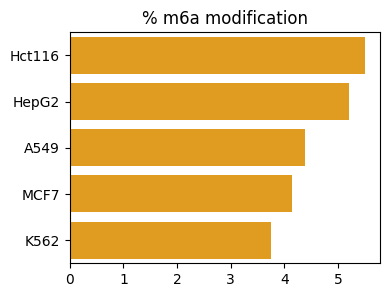

In [16]:
plt.figure(figsize=(4,3))
sns.barplot(data=perc_m6a, x='pred_label', y='cell_line', order=perc_m6a.sort_values('pred_label', ascending=False)['cell_line'], orient='h', color='orange')
plt.ylabel('')
plt.xlabel('')
plt.title('% m6a modification')
plt.savefig('../outputs/perc_m6a.png', bbox_inches='tight')

### Positions of m6a modification in each cell line

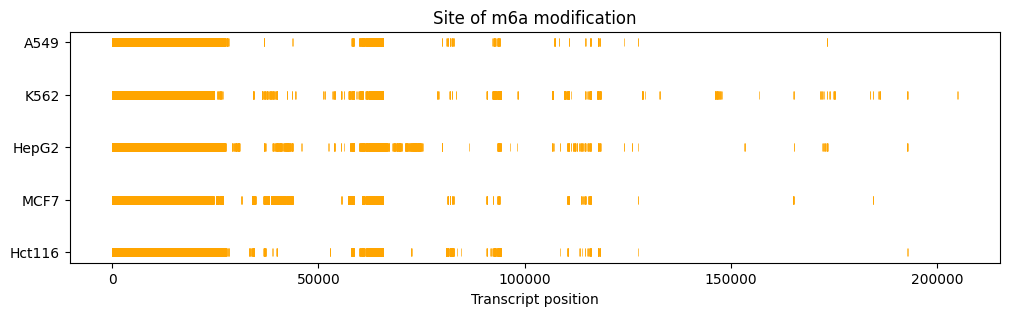

In [18]:
plt.figure(figsize=(12,3))
sns.scatterplot(data=dfa, x='transcript_position', y='cell_line', marker='|', color='orange')
plt.ylabel('')
plt.xlabel('Transcript position')
plt.title('Site of m6a modification')
plt.savefig('../outputs/site_m6a.png', bbox_inches='tight')

### Model interpretation

In [19]:
g = xgb.to_graphviz(model, num_trees=0, rankdir='LR')
g.format = 'png'
g.render('../outputs/xgbtree')

'../outputs/xgbtree.png'

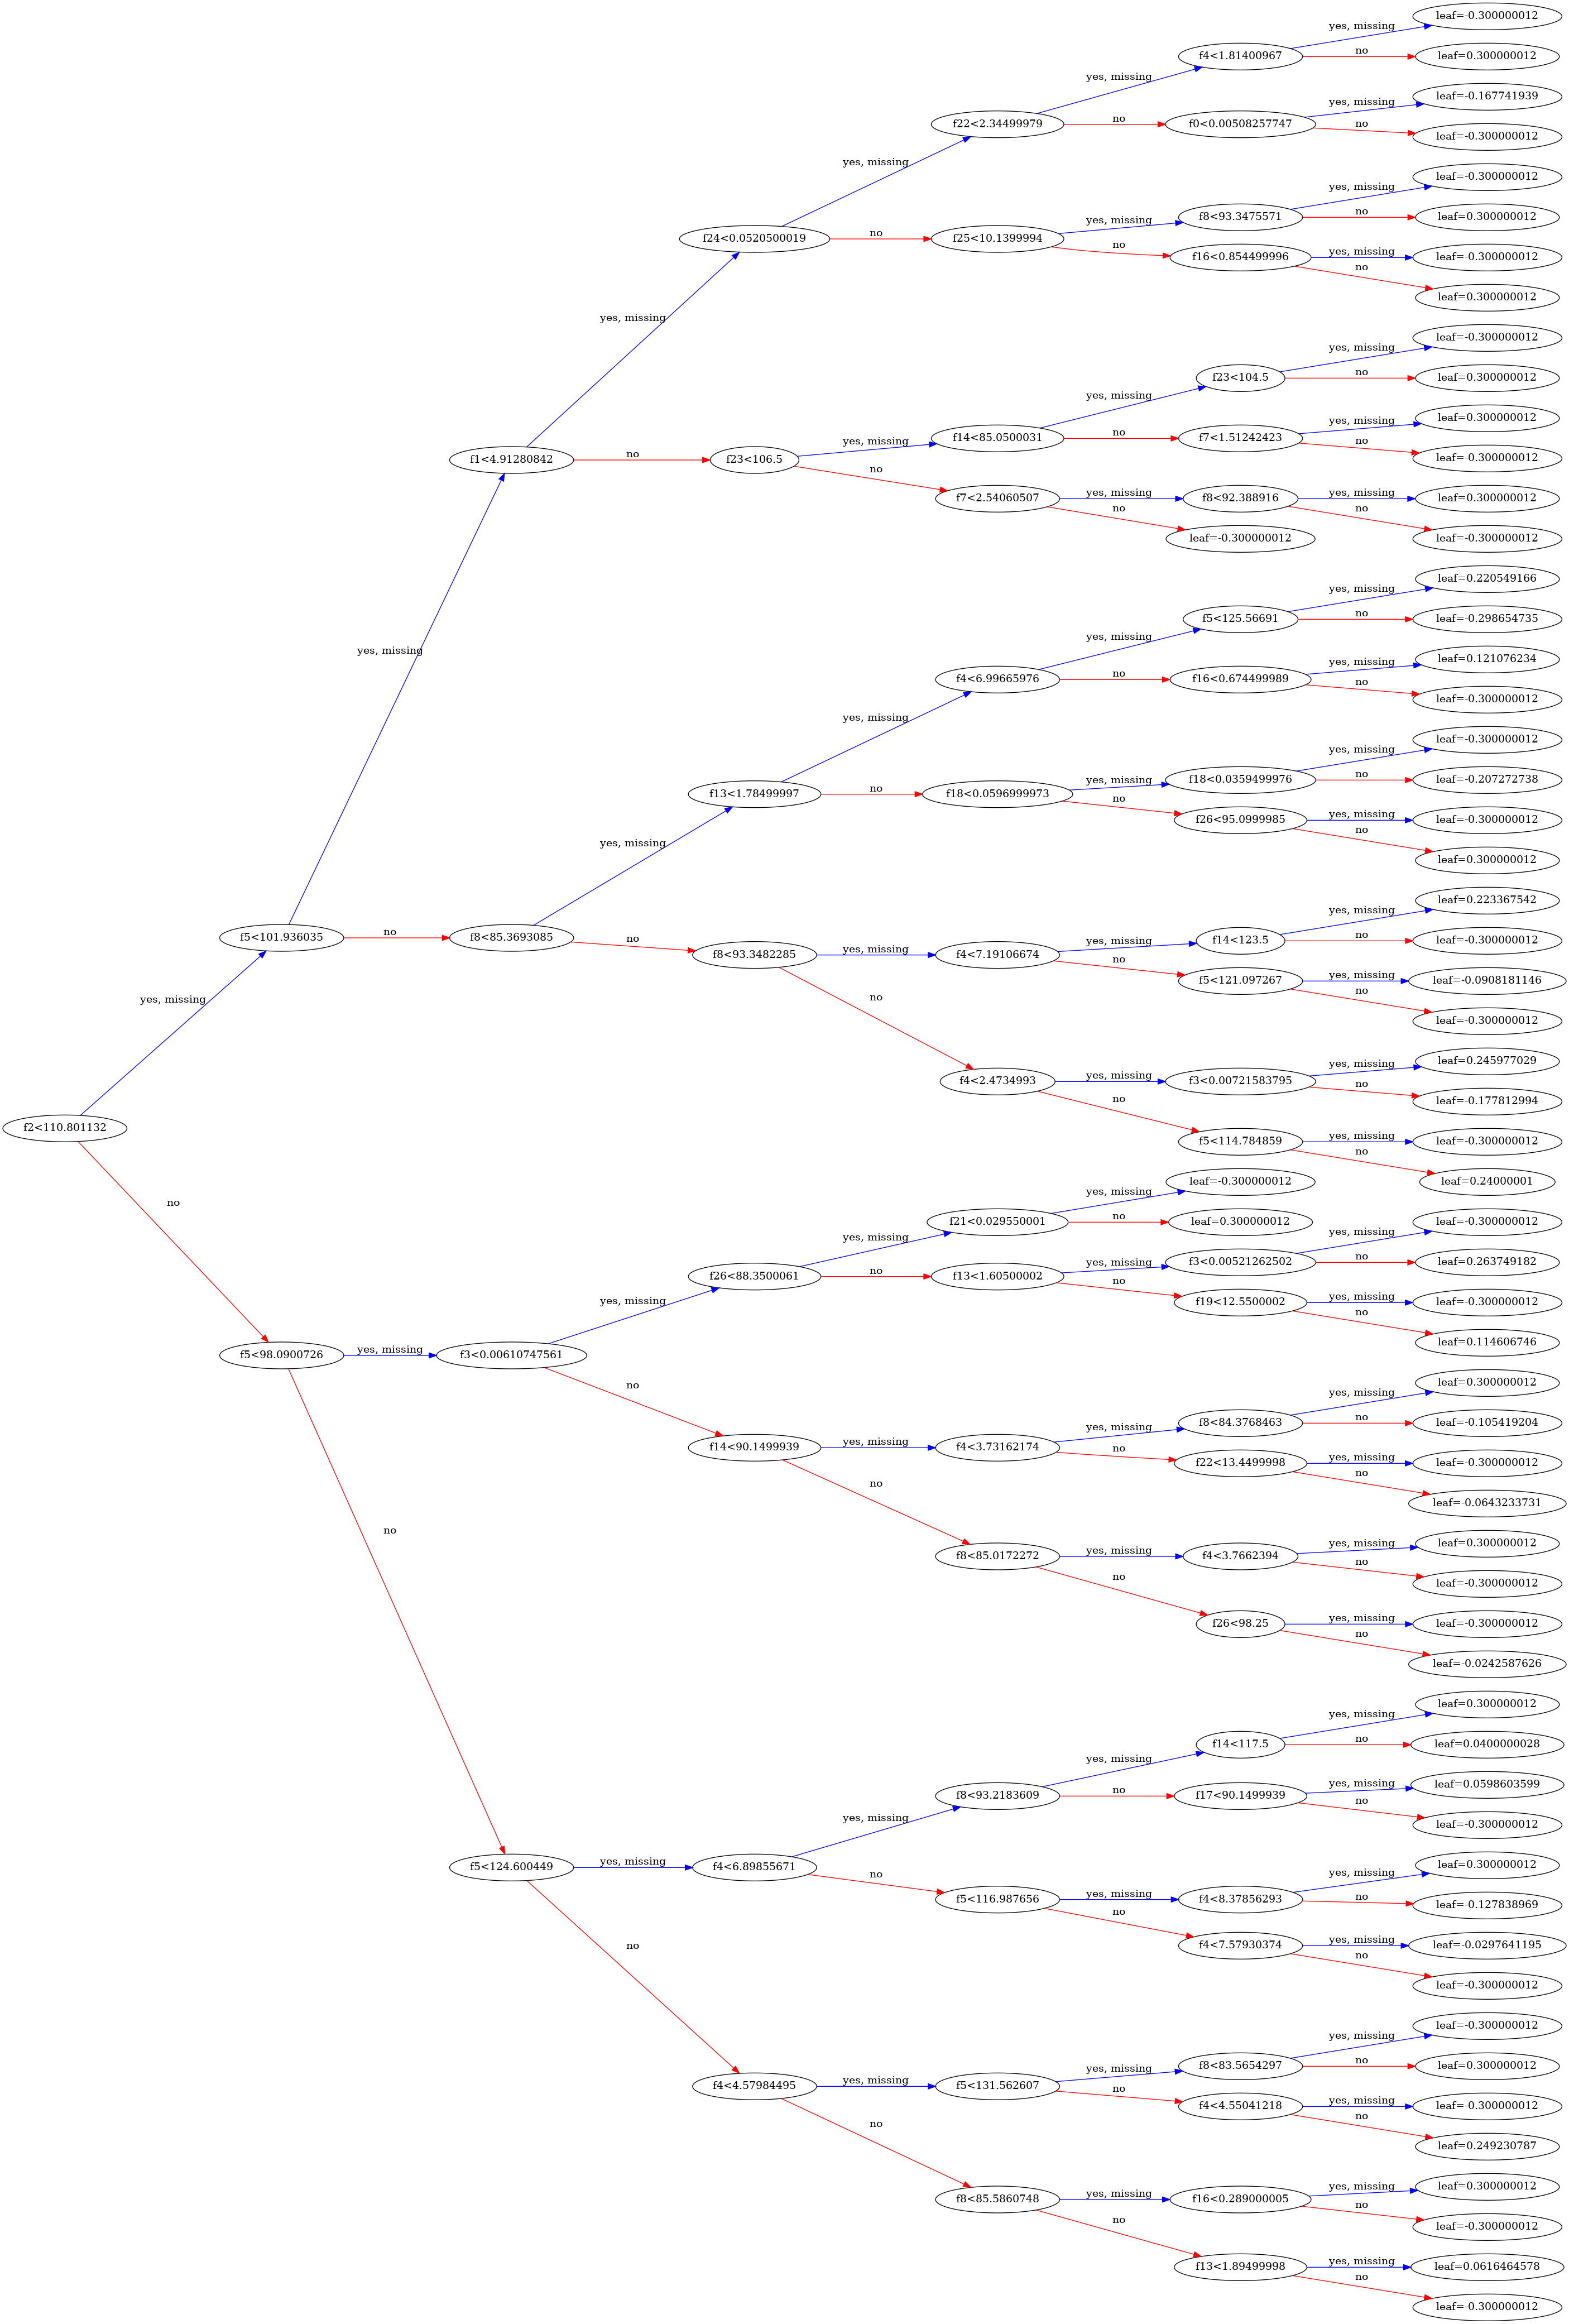

In [22]:
Image(filename='../outputs/xgbtree.png', unconfined=True) 

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

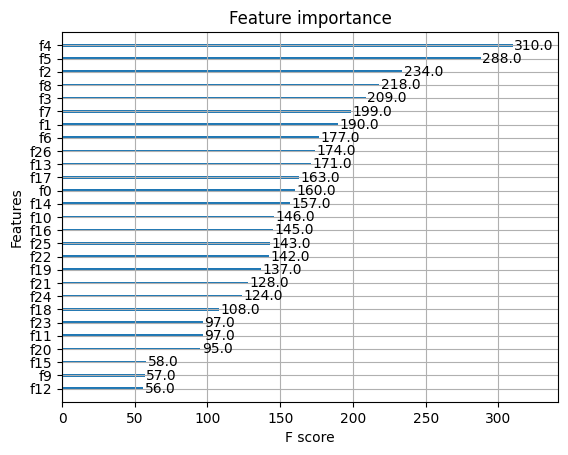

In [23]:
xgb.plot_importance(model)

<AxesSubplot: xlabel='pred_label', ylabel='count'>

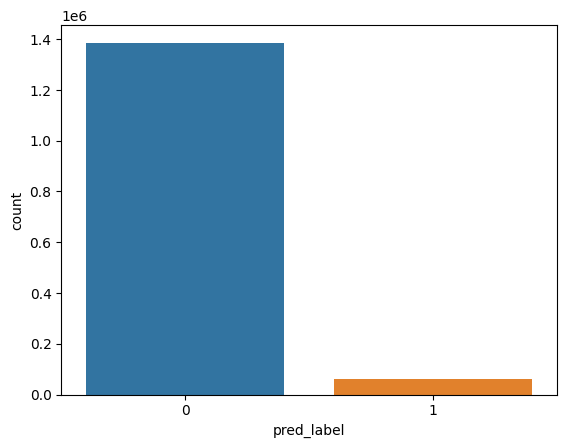

In [24]:
# for any cell line x, how many 1s & 0s?
sns.countplot(x=df['pred_label'])

<AxesSubplot: xlabel='0', ylabel='Count'>

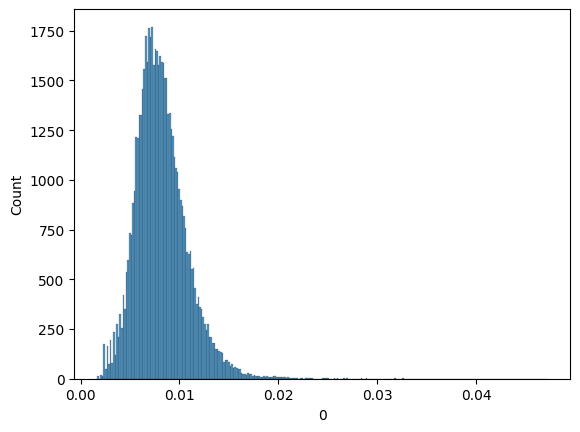

In [25]:
sns.histplot(df[df['pred_label']==1]['0'])

## Proportion of A/T/G/C at n-th nucleotide position

In [9]:
with open(os.path.join(MODEL_DIR, 'xgb4_1_feature_names.pickle'), 'rb') as f:
    feature_lst = pickle.load(f)

In [18]:
feature_lst2 = feature_lst[14:24]
w = [0.1333, 0.7051, 0.1616, 0.1861, 0.8139, 1, 1, 0.2873, 0.133, 0.5796]
wo = [0.3974, 0.3264, 0.2763, 0.4818, 0.5182, 1, 1, 0.3809, 0.3097, 0.3095]

In [58]:
dfs = pd.DataFrame(data={'position': feature_lst2, 
                         'with': w, 
                         'without': wo})

dfs1 = pd.melt(dfs, id_vars = "position", var_name="Presence of m6a")

In [59]:
dfs1

,position,Presence of m6a,value
0,p2_A,with,0.1333
1,p2_G,with,0.7051
2,p2_T,with,0.1616
3,p3_A,with,0.1861
4,p3_G,with,0.8139
5,p4_A,with,1.0000
6,p5_C,with,1.0000
7,p6_A,with,0.2873
8,p6_C,with,0.1330
9,p6_T,with,0.5796


<Figure size 400x300 with 0 Axes>

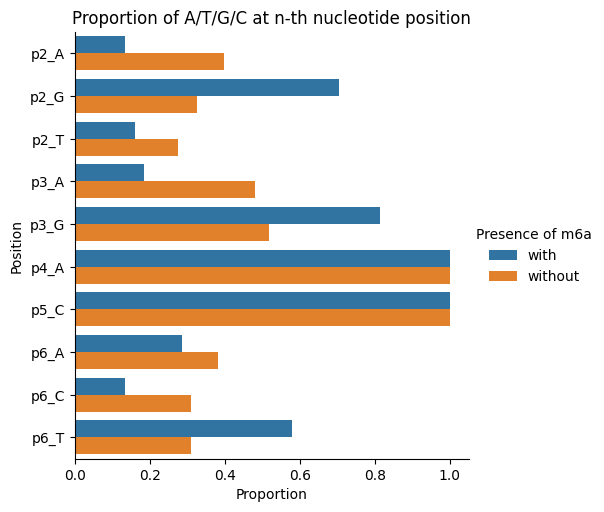

In [61]:
plt.figure(figsize=(4,3))
catp = sns.catplot(y='position', x='value', hue='Presence of m6a', data=dfs1, kind='bar', orient='h')
plt.ylabel('Position')
plt.xlabel('Proportion')
plt.title('Proportion of A/T/G/C at n-th nucleotide position')
plt.savefig('../outputs/proportion_atgc_nth_pos.png', bbox_inches='tight')